# Step 1: Import and Preprocess Data

In [1]:
# Step 1: Import and Preprocess Data
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima import auto_arima
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
import time
import itertools
from itertools import product

# Load the dataset
file_path = 'Resources/CMPD_VIOLENT_DATES.csv'
crime_data = pd.read_csv(file_path)

# Preprocess the Data
crime_data['DATE_REPORTED'] = pd.to_datetime(crime_data['DATE_REPORTED'])
daily_crime = crime_data.groupby('DATE_REPORTED').size().reset_index(name='Crime_Count')

# Create a complete date range and fill missing dates with 0
date_range = pd.date_range(start='2017-01-01', end='2024-11-20')
daily_crime = daily_crime.set_index('DATE_REPORTED').reindex(date_range, fill_value=0).reset_index()
daily_crime.columns = ['DATE_REPORTED', 'Crime_Count']

# Verify that the data is complete and in the correct format
print(f"Data starts at {daily_crime['DATE_REPORTED'].min()} and ends at {daily_crime['DATE_REPORTED'].max()}")
print(f"Data type of 'DATE_REPORTED': {daily_crime['DATE_REPORTED'].dtype}")
print(f"Number of missing values: {daily_crime.isna().sum().sum()}")



Data starts at 2017-01-01 00:00:00 and ends at 2024-11-20 00:00:00
Data type of 'DATE_REPORTED': datetime64[ns]
Number of missing values: 0


# Step 2: Decompose Time Series

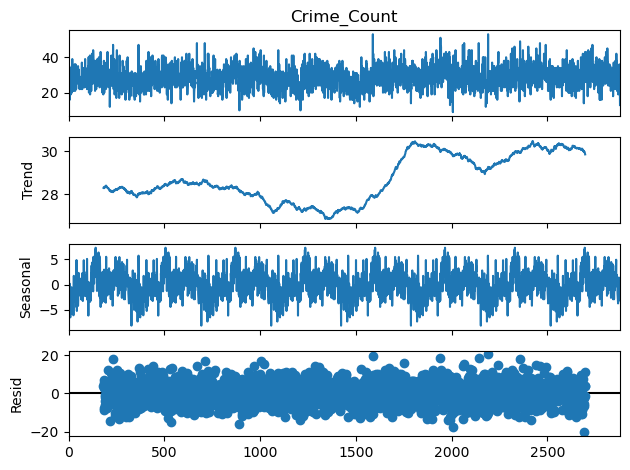

In [2]:
# Step 2: Decompose Time Series
decomposition = seasonal_decompose(daily_crime['Crime_Count'], period=365, model='additive')
decomposition.plot()
plt.savefig('CMPD_CRIME_By_Month_OPTIMIZED.png')
plt.show()

# Step 3: Fit SARIMA Model with Initial Parameters

In [3]:
# Step 3: Fit SARIMA Model with Initial Parameters
# Aggregate to monthly data to reduce noise
monthly_crime = daily_crime.resample('M', on='DATE_REPORTED').sum()

# Fit SARIMA model with initial parameters
sarima_model = SARIMAX(
    monthly_crime['Crime_Count'],
    order=(2, 1, 0),
    seasonal_order=(0, 1, 1, 12),  # Seasonal terms for monthly data
    enforce_stationarity=False,
    enforce_invertibility=False
)
sarima_results = sarima_model.fit()
print(sarima_results.summary())


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.11455D+00    |proj g|=  1.34518D-01

At iterate    5    f=  4.09237D+00    |proj g|=  4.17780D-03

At iterate   10    f=  4.08111D+00    |proj g|=  4.57288D-02

At iterate   15    f=  4.07505D+00    |proj g|=  1.21443D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     19     22      1     0     0   6.481D-06   4.075D+00
  F =   4.0747123811097756     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
        

/var/folders/z3/mxhxwwgj7bb1sd23lpfhh6h80000gn/T/ipykernel_46382/565995013.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_crime = daily_crime.resample('M', on='DATE_REPORTED').sum()
 This problem is unconstrained.


# Step 4: Evaluate Initial Model

In [4]:
# Step 4: Evaluate Initial Model
# Split the data into train and test sets (monthly aggregated data)
train = monthly_crime[monthly_crime.index < '2024-01-01']
test = monthly_crime[monthly_crime.index >= '2024-01-01']

# Make predictions on the test set
test['Predicted'] = sarima_results.get_prediction(start=test.index[0], end=test.index[-1]).predicted_mean

# Calculate performance metrics
mae = mean_absolute_error(test['Crime_Count'], test['Predicted'])
rmse = mean_squared_error(test['Crime_Count'], test['Predicted'], squared=False)
r_squared = 1 - (sum((test['Crime_Count'] - test['Predicted']) ** 2) /
                 sum((test['Crime_Count'] - test['Crime_Count'].mean()) ** 2))

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared: {r_squared}")

/var/folders/z3/mxhxwwgj7bb1sd23lpfhh6h80000gn/T/ipykernel_46382/1603476944.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predicted'] = sarima_results.get_prediction(start=test.index[0], end=test.index[-1]).predicted_mean


Mean Absolute Error (MAE): 73.42347266791323
Root Mean Squared Error (RMSE): 105.76593366205641
R-squared: 0.21089301981911734


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


# Step 5: Optimize SARIMA Model (Grid Search)

In [5]:
# Step 5: Optimize SARIMA Model (Expanded Grid Search)
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.diagnostic import acorr_ljungbox

# Expanded parameter grid for SARIMA
p = range(0, 3)
d = [1]
q = range(0, 3)
P = range(0, 3)
D = [1]
Q = range(0, 3)
s = [12]  # Seasonality (monthly)

# Best model initialization
best_model = None
best_aic = float("inf")
best_params = None

# Grid Search for SARIMA Parameters
for param in [(x[0], x[1], x[2]) for x in itertools.product(p, d, q)]:
    for seasonal_param in [(x[0], x[1], x[2], s[0]) for x in itertools.product(P, D, Q)]:
        try:
            model = SARIMAX(
                monthly_crime['Crime_Count'],
                order=param,
                seasonal_order=seasonal_param,
                enforce_stationarity=False,
                enforce_invertibility=False
            )
            results = model.fit(disp=False)
            if results.aic < best_aic:
                best_aic = results.aic
                best_model = results
                best_params = (param, seasonal_param)
        except Exception as e:
            continue

print(f"Best SARIMA Parameters: {best_params}")
print(f"Best AIC: {best_aic}")

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: M

Best SARIMA Parameters: ((2, 1, 1), (2, 1, 0, 12))
Best AIC: 640.6733513277534


/opt/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


# Step 6: Evaluate Optimized Model

/var/folders/z3/mxhxwwgj7bb1sd23lpfhh6h80000gn/T/ipykernel_46382/1515489916.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Optimized_Predicted'] = optimized_results.get_prediction(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Optimized Mean Absolute Error (MAE): 78.36515696479229
Optimized Root Mean Squared Error (RMSE): 99.91141250953196
Optimized R-squared: 0.2958349468621114


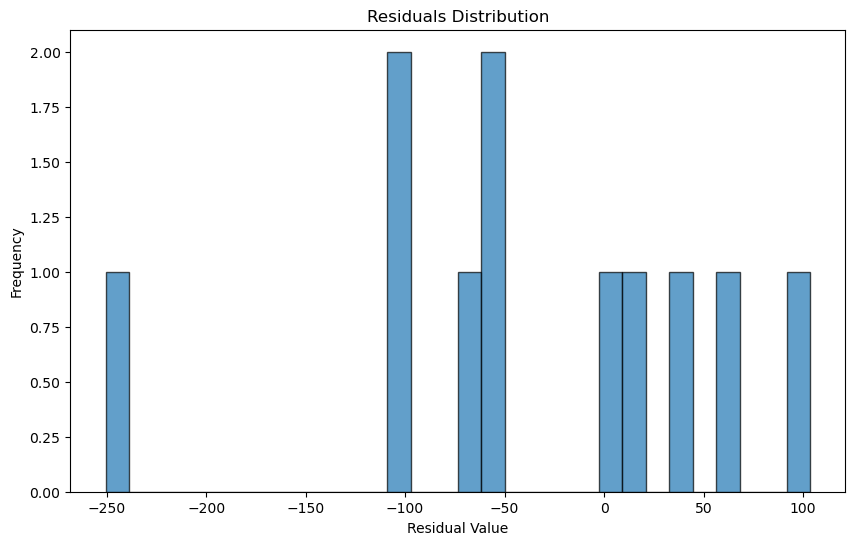

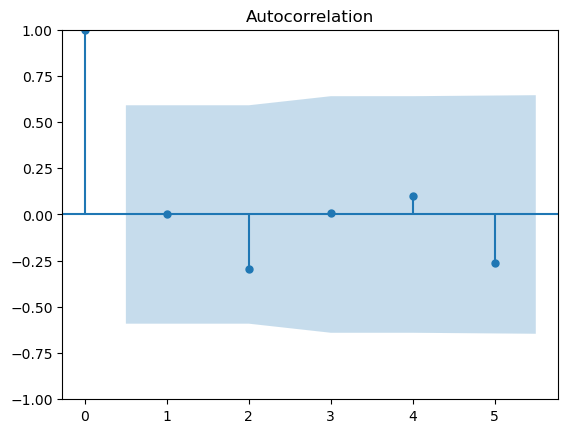

Ljung-Box Test:
      lb_stat  lb_pvalue
10  10.821958   0.371556


In [6]:
# Step 6: Evaluate the Optimized Model
optimized_results = best_model

# Predictions
test['Optimized_Predicted'] = optimized_results.get_prediction(
    start=test.index[0], end=test.index[-1]
).predicted_mean

# Calculate performance metrics
mae_opt = mean_absolute_error(test['Crime_Count'], test['Optimized_Predicted'])
rmse_opt = mean_squared_error(test['Crime_Count'], test['Optimized_Predicted'], squared=False)
r_squared_opt = 1 - (sum((test['Crime_Count'] - test['Optimized_Predicted']) ** 2) /
                     sum((test['Crime_Count'] - test['Crime_Count'].mean()) ** 2))

print(f"Optimized Mean Absolute Error (MAE): {mae_opt}")
print(f"Optimized Root Mean Squared Error (RMSE): {rmse_opt}")
print(f"Optimized R-squared: {r_squared_opt}")

# Residual Analysis
residuals = test['Crime_Count'] - test['Optimized_Predicted']
plt.figure(figsize=(10, 6))
plt.title("Residuals Distribution")
plt.hist(residuals, bins=30, edgecolor='k', alpha=0.7)
plt.xlabel("Residual Value")
plt.ylabel("Frequency")
plt.savefig('CMPD_CRIME_Data_Residuals_Distribution_OPTIMIZED.png')
plt.show()

# Check for autocorrelation in residuals
plot_acf(residuals)
plt.savefig('CMPD_CRIME_Autocorrelation_OPTIMIZED.png')
plt.show()

# Ljung-Box test for autocorrelation
lb_test = acorr_ljungbox(residuals, lags=[10], return_df=True)
print("Ljung-Box Test:")
print(lb_test)

# Step 7: Forecast with Optimized Model


/var/folders/z3/mxhxwwgj7bb1sd23lpfhh6h80000gn/T/ipykernel_46382/282443313.py:4: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_index = pd.date_range(start='2024-12-01', periods=forecast_steps, freq='M')


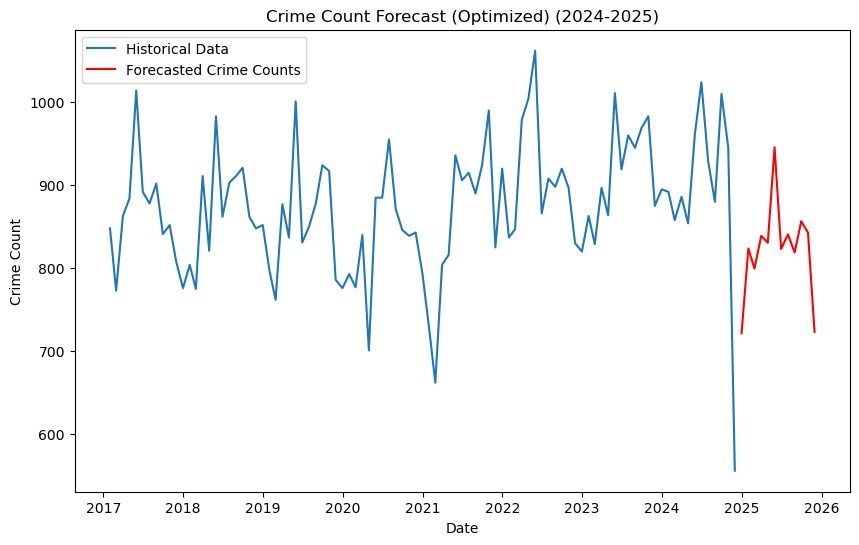

In [7]:
# Step 7: Forecast with Optimized Model
forecast_steps = 12  # Forecast 12 months ahead
forecast = optimized_results.get_forecast(steps=forecast_steps)
forecast_index = pd.date_range(start='2024-12-01', periods=forecast_steps, freq='M')
forecast_values = forecast.predicted_mean

# Visualize the forecast
plt.figure(figsize=(10, 6))
plt.plot(monthly_crime.index, monthly_crime['Crime_Count'], label='Historical Data')
plt.plot(forecast_index, forecast_values, label='Forecasted Crime Counts', color='red')
plt.title('Crime Count Forecast (Optimized) (2024-2025)')
plt.xlabel('Date')
plt.ylabel('Crime Count')
plt.legend()
plt.savefig('CMPD_CRIME_FORECAST_2024_2025_OPTIMIZED.png')
plt.show()